In [1]:
from torchvision import models,transforms,datasets
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torch
import time
from sklearn.svm import SVR
from collections import defaultdict

In [2]:
# prediction
def test_perf(model,input_concat,feat_model):
    inputs = Variable(input_concat.cuda())
    feat = feat_model.features(inputs)
    inputs_2 = feat.view(feat.size(0), -1)
    outputs = model(inputs_2)
    _,pred = torch.max(outputs.data,1)
   
    return pred.cpu().numpy()

In [7]:
def classify(path):
    # Load images
    test_case = [Image.open(os.path.join(path,i)).convert('RGB') for i in os.listdir(path) ]
    
    # Image transform
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    prep2 = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    
    test_case_tensor = [prep2(d).unsqueeze_(0) for d in test_case]
    input_concat = reduce(lambda x,y:torch.cat((x,y),0),test_case_tensor)
    
    # Load tuned classifiers
    model_vgg = models.vgg16(pretrained=True)
    model_age = torch.load('classifier_age_balance.pt')
    model_gender = torch.load('classifier_gender.pt')
    model_race = torch.load('classifier_race.pt')
    
    # checking for GPU
    if torch.cuda.is_available():
        model_vgg = model_vgg.cuda()
        model_age = model_age.cuda()
        model_gender = model_gender.cuda()
        model_race = model_race.cuda()
    
    # Hashtable for labels
    gender_dict = {0:'Male',1:'Female'}
    race_dict = {0:'White',1:'Black',2:'Asian',3:'Indian',4:'Others'}
    age_dict =  {0: '1~1',
                 1: '2~4',
                 2: '5~10',
                 3: '11~16',
                 4: '17~21',
                 5: '22~24',
                 6: '25~26',
                 7: '27~28',
                 8: '29~30',
                 9: '31~32',
                 10: '33~35',
                 11: '36~38',
                 12: '39~42',
                 13: '43~47',
                 14: '48~52',
                 15: '53~56',
                 16: '57~62',
                 17: '63~68',
                 18: '69~74',
                 19: '75~80',
                 20: '81~86',
                 21: '87~92',
                 22: '93~101',
                 23: '103~116'}
    
    
    # Start classification
    predict_age = test_perf(model_age, input_concat,model_vgg)
    predict_gender = test_perf(model_gender, input_concat,model_vgg)
    predict_race = test_perf(model_race, input_concat,model_vgg)
    
    # Hashing to practical labels
    result_gender = [gender_dict[d] for d in predict_gender]
    result_race = [race_dict[d] for d in predict_race]
    result_age = [age_dict[d] for d in predict_age]
    
    # Plot the result
    for i in range(len(test_case)):
        f,ax = plt.subplots()
        ax.imshow(test_case[i])
        ax.set_title(result_gender[i] + ' ' + result_race[i] + ' ' + str(result_age[i]))
    

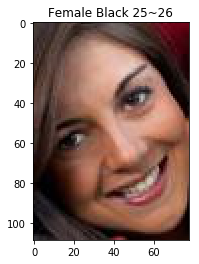

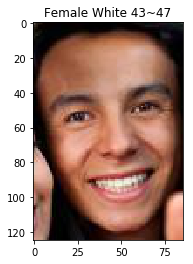

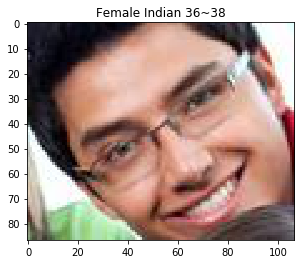

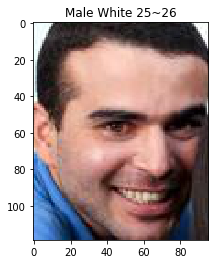

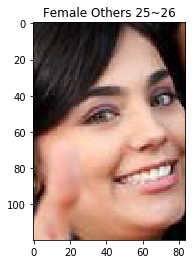

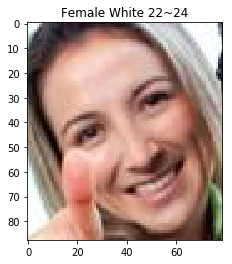

In [8]:
if __name__ == "__main__":
    classify('yolo_output3')